<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/GPR_PSO_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Importing packages


In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
data preparation
We generate the first 3 main principal components that capture the most useful information of the data. P1, P2 and P3 are not correalted with each other while they are epressed as the linear cominination of the available featurdes, i.e. ET0, VPD, Rn and T (air temperature)

**Note:** Make sure that the data file is addressed correctly and it's already avaialble in your Google drive.

In [2]:

# dataFile = 'Changde.xlsx'  
dataFile = 'Hailisu.xlsx'  
# dataFile = 'Lancang.xlsx'  
# dataFile = 'Miyun.xlsx'  
# dataFile = 'Nanmulin.xlsx'  
# dataFile = 'Qiemo.xlsx'

data = pd.read_excel('/content/drive/My Drive/'+ dataFile)

In [3]:
# revising the column names
for col in data.columns:
  newcol = col.split("(")[0].strip()
  data.rename(columns={col:newcol}, inplace=True)

# setting up the index of the data frame
data.set_index("TIMESTAMP", inplace=True)

# resample data daily, forward linear interpolation to fill the missing values
data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

## Optional:
## Generating the first three principal (P1, P2, P3) components basesd on ET0, VPD, Rn and T.
myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(myData)
pca_data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
data["P1"] = pca_data[:,0]
data["P2"] = pca_data[:,1]
data["P3"] = pca_data[:,3]

# displaying the first couple rows of the data table
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3
TIMESTAMP,,,,,,,,,,,,,,,
1990-01-01,1,4.5,-15.9,1.4,74.0,-20.3,-10.8,2.194157,0.049189,0.014773,0.067364,0.353247,-2.604686,0.219401,0.051999
1990-01-02,2,6.3,-14.7,1.2,55.0,-21.6,-7.2,2.455747,0.098182,0.016148,0.067364,0.708336,-2.433856,0.237608,0.013234
1990-01-03,3,6.5,-10.5,1.8,63.0,-15.0,-5.6,2.851274,0.105714,0.021875,0.067364,0.773378,-2.218240,0.177261,0.023540
1990-01-04,4,6.8,-14.6,1.4,71.0,-18.5,-8.6,2.698292,0.057183,0.016267,0.067364,0.455943,-2.477608,0.140149,0.051026
1990-01-05,5,5.8,-15.2,1.1,55.0,-22.2,-5.9,2.000768,0.090000,0.015562,0.067364,0.627822,-2.522159,0.310003,0.011304


# Staging some data for ML modeling


Generating train and test data sets.
For the sake of speed, we use use a fraction of data for evaluation of our algorithm. Later to get the final results, we use the entire data set.

Text(0.5, 0, 'Time')

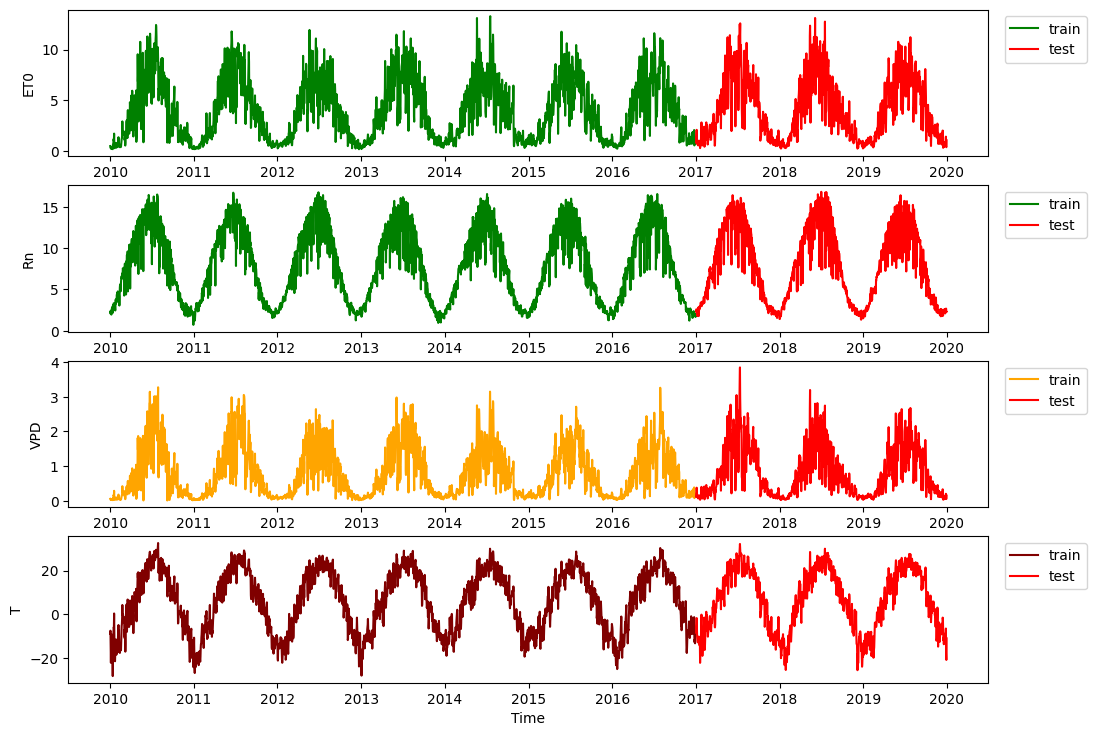

In [4]:
fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

# training: 2010-2017
subData = data.loc["2010":"2016-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"].ffill()
z = subData["Rn"].ffill()
v = subData["VPD"].ffill()
w = subData["T"].ffill()


# testing: 2013 onward
subData_test = data.loc["2017":]
N_test = len(subData_test)
x_test = subData_test.index
y_test = subData_test["ET0"].ffill()
z_test = subData_test["Rn"].ffill()
v_test = subData_test["VPD"].ffill()
w_test = subData_test["T"].ffill()

# top plot 
p = 0

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, y, color='green', label="train")
ax.plot(x_test, y_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("ET0")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, z, color='green', label="train")
ax.plot(x_test, z_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("Rn")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, v, color='orange', label="train")
ax.plot(x_test, v_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("VPD")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, w, color='maroon', label="train")
ax.plot(x_test, w_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("T")


ax.set_xlabel("Time")

In [5]:
def dataPrepare2(y, z, v, w, n = 3, d = 1):
  '''
  Generating discrete data points out of the given series

  y: main signal, e.g. ET0
  z, v, w: auxiliary signals (set these to zero (e.g z=y*0) if not interested)
  n: the number of previous data points that are used for forcasting
  d: the number of days ahead for forecasting

  output: feature matrix XS, and target values ys
  '''

  N = len(y)
  dd = d - 1

  XS = np.zeros((N-n-dd, n))
  ys = np.zeros(N-n-dd)

  for i in range(0, N-n-dd):
    XS[i,:n] = y[i:i+n]  
    # XS[i,n:2*n] = z[i:i+n]
    # XS[i,2*n:3*n] = v[i:i+n]   
#     XS[i,3*n:4*n] = w[i:i+n] 
    
    ys[i] = y[i+n+dd]
  # 
  return XS, ys

In [14]:
from sklearn.preprocessing import MinMaxScaler


lag = 15
d = 1

y_train_lag = y[-lag:]

print(y_train_lag.shape)
assert y_train_lag.shape == (lag,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

new_test_series =  pd.concat([y_train_lag, y_test])

sc = MinMaxScaler(feature_range=(0,1))
ys = sc.fit_transform(y.values.reshape(-1,1)).reshape(-1)
ys_test = sc.fit_transform(new_test_series.values.reshape(-1,1)).reshape(-1)

(15,)


In [15]:
# y: ET0 
# z: P1 (the first principal component)
# v: T (temperature)
# w: VPD

XS_train, ys_train = dataPrepare2(ys, z, v, w, n=lag, d=d)
XS_test, ys_test = dataPrepare2(ys_test, z_test, v_test, w_test, n=lag, d=d)

print(XS_train.shape, ys_train.shape)
print(XS_test.shape, ys_test.shape)

(2542, 15) (2542,)
(1095, 15) (1095,)


In [16]:
# Reshaping X_train for efficient modeling
XS_train = np.reshape(XS_train, (XS_train.shape[0],XS_train.shape[1], 1))

In [17]:
XS_train.shape

(2542, 15, 1)

In [18]:
# %tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(XS_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(optimizer='rmsprop', loss='mse')

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [19]:
regressor.fit(XS_train,ys_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/15
36/36 [==============================] - 1s 21ms/step - loss: 0.0174 - val_loss: 0.0226
Epoch 2/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0219
Epoch 3/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0212
Epoch 4/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0208
Epoch 5/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0203
Epoch 6/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0199
Epoch 7/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0193
Epoch 8/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0188
Epoch 9/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0182
Epoch 10/15
36/36 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0175
Epoch 11/15
36/36 

In [24]:
XS_test = np.reshape(XS_test, (XS_test.shape[0],XS_test.shape[1], 1))

predicted = regressor.predict(XS_test)
# predicted_revtrans = sc.inverse_transform(predicted).ravel()


In [26]:
def metrics(y1, y2):
  '''
  y1 and y2 are two series of the same size

  This function outputs the MAE, RMSE and R^2 
  of the cross evaluated series.

  '''
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################

In [30]:
print("Test set: ")

metrics(ys_test, predicted)


Test set: 
MAE: 0.08  RMSE: 0.11  R^2: 0.79


Text(0.5, 1.0, '1 day ahead predictions (Test)')

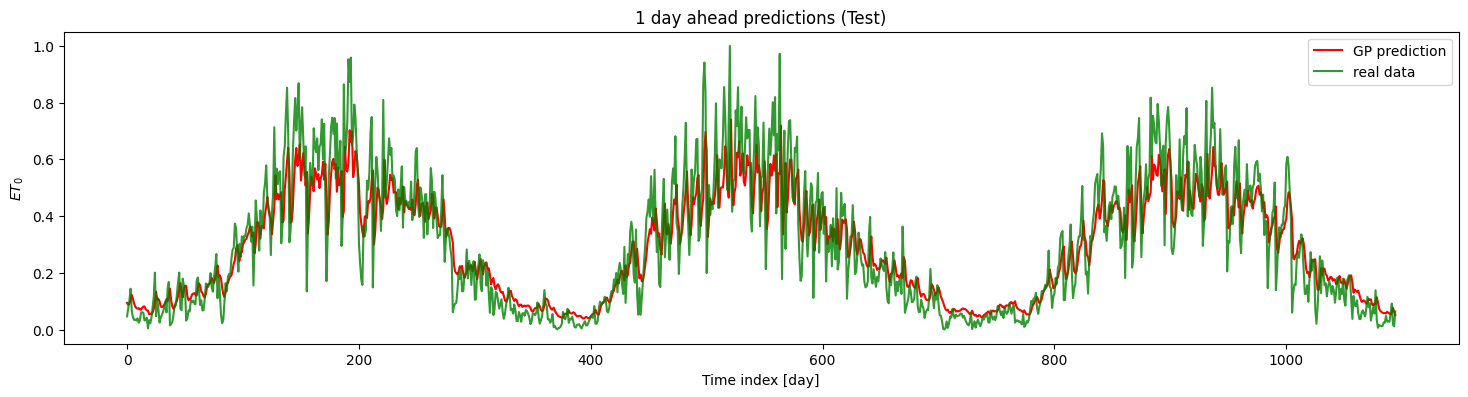

In [34]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# ax.plot(gp_yp, 'r.-',  alpha=1)
# ax.plot(ys2, 'g.-', alpha=0.8)

ax.plot(predicted, 'r-',  alpha=1, label='GP prediction')
ax.plot(ys_test, 'g-', alpha=0.8, label='real data')


ax.legend()
# ax.set_xlim(0,1000)
ax.set_ylabel("$ET_0$")
ax.set_xlabel("Time index [day]")
ax.set_title("1 day ahead predictions (Test)")

Text(0.5, 1.0, 'Hailisu')

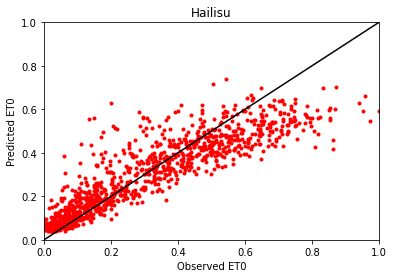

In [36]:
plt.plot(ys_test, predicted, 'r.')

plt.plot([0, 8], [0, 8], 'k-')

plt.xlabel("Observed ET0")
plt.ylabel("Predicted ET0")

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Hailisu")

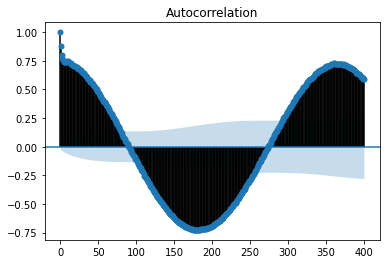

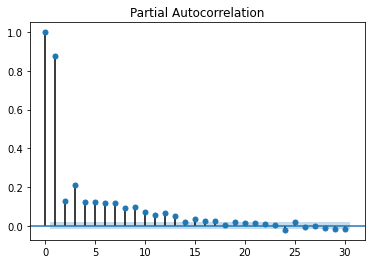

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = data["ET0"].ffill().bfill()#.fillna(1)

plot_acf(y, lags=400) ; plt.show()
plot_pacf(y, lags=30) ; plt.show()